In [151]:
#@title Import Dependencies
import matplotlib
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

In [152]:
#@title Define Hyperparameters

input_size = 784 # img_size = (28,28) ---> 28*28=784 in total
hidden_size = 500 # number of nodes at hidden layer
num_classes = 10 # number of output classes discrete range [0,9]
num_epochs = 50 # number of times which the entire dataset is passed throughout the model
batch_size = 100 # the size of input data took for one iteration
lr = 1e-2 # size of step 

In [153]:
#@title Downloading MNIST data

train_data = dsets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = dsets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())

In [154]:
#@title Loading the data

train_gen = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size, 
                                      shuffle = False)

In [155]:
from torch.autograd import Function

class PhotonCountingP(nn.Module):
    """ The probability of 1 photon in photon counting 
        (also the expectation value) with mean flux x """
    def __init__(self):
        super(PhotonCountingP, self).__init__()

    def forward(self, x):
        return 1.-torch.exp(torch.abs(x)*-1.)
    
class BernoulliFunctionST(Function):
    """ The 'Straight Through' stochastic Bernoulli activation"""
    @staticmethod
    def forward(ctx, input):

        return torch.bernoulli(input)

    @staticmethod
    def backward(ctx, grad_output):

        return grad_output

class PoissonFunctionST(Function):
    """ The 'Straight Through' stochastic Poisson activation"""
    @staticmethod
    def forward(ctx, input):

        return torch.poisson(input)

    @staticmethod
    def backward(ctx, grad_output):

        return grad_output
    
PoissonST = PoissonFunctionST.apply    
BernoulliST = BernoulliFunctionST.apply 

In [143]:
# #for photonActivation

# class Net(nn.Module):
#   def __init__(self, input_size, hidden_size, num_classes, scale = 1, slope = 1, repeat = 5):
#     super(Net,self).__init__()
#     self.fc1 = nn.Linear(input_size, hidden_size)
#     self.relu = nn.ReLU()
#     self.fc2 = nn.Linear(hidden_size, num_classes)
#     self.act = PhotonCountingP()
#     self.sampler = BernoulliST
#     self.scale = scale
#     self.slope = slope
#     self.repeat = repeat
  
#   def forward(self,x):
#     out = self.fc1(x)
#     # out = self.relu(out)
#     probs = self.act(self.slope * out)
#     out = self.sampler(probs.unsqueeze(0).repeat((self.repeat,)+(1,)*len(probs.shape))).mean(axis=0)*torch.sign(out)
#     out = self.fc2(out)
#     return out

In [156]:

# for poisson
from torch.distributions import Exponential

def sample_poisson_relaxed(lmbd, num_samples=5, temperature = 0.01):
    try:
        sampler = torch.empty(num_samples)
        z = Exponential(lmbd).rsample(sampler.size())
        t = torch.cumsum(z, 0)
        relaxed_indicator = torch.sigmoid((1.0 - t) / temperature)
        N = torch.cumsum(relaxed_indicator, 0)
        return N[-1]
    except Exception:
        return lmbd

def bernoulli_sample(lmbd, num_samples = 1):
  ones = torch.ones_like(lmbd)
  negativelmbd = torch.mul(lmbd, -1)
  probs = torch.sub(ones, torch.exp(negativelmbd)) 
  sample = torch.randn_like(lmbd) #add some way of taking an average of samples
  out = torch.where(probs > sample, 1.0, 0.0) #will return 1 if probs > sample (ie. there is a shot detected from [1-e^-lmbd])
  return out


import torch.nn.functional as F

def bernoulli_reparam(lmbd):
  # print(ones)
  negativelmbd = torch.mul(lmbd, -1)
  # print(negativelmbd)
  zeroprobs = torch.exp(negativelmbd) #this will be e^-lmbd
  # print(zeroprobs)
  zeroprobs = torch.unsqueeze(zeroprobs, 2)
  # print(zeroprobs)
  ones = torch.ones_like(zeroprobs)
  oneprobs = torch.sub(ones, zeroprobs) # 1-e^-lmbd
  # print(oneprobs)
  logits = torch.cat([oneprobs, zeroprobs], 2)
  # print(logits)
  sample = F.gumbel_softmax(logits, hard=False) #[a,b] where a=1 if there is a detection and b=1 if there is not
  out = sample[:,:,0] #i think this will be 1 if there is a detection and 0 otherwise
  # print(out)
  return(out)
    
class Net(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes, scale = 1, slope = 1, repeat = 5):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    # self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)
    self.repeat = repeat
  
  def forward(self,x):
    out = self.fc1(x)
    # out = sample_poisson_relaxed(torch.square(out), self.repeat)
    # out = bernoulli_sample(sample_poisson_relaxed(torch.square(out), self.repeat))
    out = bernoulli_reparam(sample_poisson_relaxed(out, self.repeat))
    # out = self.relu(out)
    out = self.fc2(out)
    return out

In [157]:
#@title Build the model

if torch.cuda.is_available():
  print(1)
else:
    print(0)
print(torch.device(0))
print(torch.version.cuda)

1
cuda:0
12.1


In [158]:
#@title Training the model


def runModel(count):
  accuracies = []
  # photonCounts = []
  hiddenLayer = []

  # finalaccuracies = []
  # finalCounts = []

  for j in [50,100,200,300,400]:
  # for j in [400]:

    hidden_size = j
    # count = j + 1
    net = Net(input_size, hidden_size, num_classes, repeat= count)
    if torch.cuda.is_available():
       net.cuda()
    loss_function = nn.CrossEntropyLoss()
    # optimizer = torch.optim.Adam( net.parameters(), lr=lr)
    optimizer = torch.optim.SGD(net.parameters(), lr = 0.1)
    # optimizer = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.99, 0.999), eps=1e-08, weight_decay=0)

    max = 0
    for epoch in range(num_epochs):
      for i ,(images,labels) in enumerate(train_gen):
        images = Variable(images.view(-1,28*28)).cuda()
        labels = Variable(labels).cuda()
        
        optimizer.zero_grad()
        outputs = net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
          print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                    %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, loss.item()))
        # if (i+1) % 100 == 0:
        #   print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Accuracy: %.1f'
        #             %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, loss.item(), accuracy))
      correct = 0
      total = 0
      for images,labels in test_gen:
        images = Variable(images.view(-1,28*28)).cuda()
        labels = labels.cuda()
        
        output = net(images)
        _, predicted = torch.max(output,1)
        correct += (predicted == labels).sum()
        total += labels.size(0)

      accuracy = (100*correct)/(total+1)
      if max < accuracy.item():
        max = accuracy.item()

    accuracies.append(max)
    hiddenLayer.append(hidden_size)
        # photonCounts.append(count)
    # finalaccuracies.append(accuracy)
    # finalCounts.append(count)
  return accuracies, hiddenLayer
        

In [159]:

# for i in range(len(accuracies)):
#     accuracies[i] = accuracies[i].item()

# for i in range(len(finalaccuracies)):
#     finalaccuracies[i] = finalaccuracies[i].item()

In [160]:
#@title Evaluating the accuracy of the model

# correct = 0
# total = 0
# for images,labels in test_gen:
#   images = Variable(images.view(-1,28*28))
#   labels = labels
  
#   output = net(images)
#   _, predicted = torch.max(output,1)
#   correct += (predicted == labels).sum()
#   total += labels.size(0)

# print('Accuracy of the model: %.3f %%' %((100*correct)/(total+1)))

In [161]:
# import matplotlib.pyplot as plt
# print(photonCounts)
# print(accuracies)
# plt.plot(photonCounts, accuracies, 'o')
# plt.plot(finalCounts, finalaccuracies)
# plt.xlabel('Number of shots')
# plt.ylabel('accuracy')
# plt.title('Shot number vs. Accuracy after 10 epochs')
# plt.show()

Epoch [1/50], Step [100/600], Loss: 1.8664
Epoch [1/50], Step [200/600], Loss: 1.2389
Epoch [1/50], Step [300/600], Loss: 1.0732
Epoch [1/50], Step [400/600], Loss: 0.9440
Epoch [1/50], Step [500/600], Loss: 0.8164
Epoch [1/50], Step [600/600], Loss: 0.6034
Epoch [2/50], Step [100/600], Loss: 0.6323
Epoch [2/50], Step [200/600], Loss: 0.5386
Epoch [2/50], Step [300/600], Loss: 0.4378
Epoch [2/50], Step [400/600], Loss: 0.3777
Epoch [2/50], Step [500/600], Loss: 0.4116
Epoch [2/50], Step [600/600], Loss: 0.5269
Epoch [3/50], Step [100/600], Loss: 0.4387
Epoch [3/50], Step [200/600], Loss: 0.4284
Epoch [3/50], Step [300/600], Loss: 0.2849
Epoch [3/50], Step [400/600], Loss: 0.4156
Epoch [3/50], Step [500/600], Loss: 0.4735
Epoch [3/50], Step [600/600], Loss: 0.4344
Epoch [4/50], Step [100/600], Loss: 0.4747
Epoch [4/50], Step [200/600], Loss: 0.3030
Epoch [4/50], Step [300/600], Loss: 0.3561
Epoch [4/50], Step [400/600], Loss: 0.4588
Epoch [4/50], Step [500/600], Loss: 0.4791
Epoch [4/50

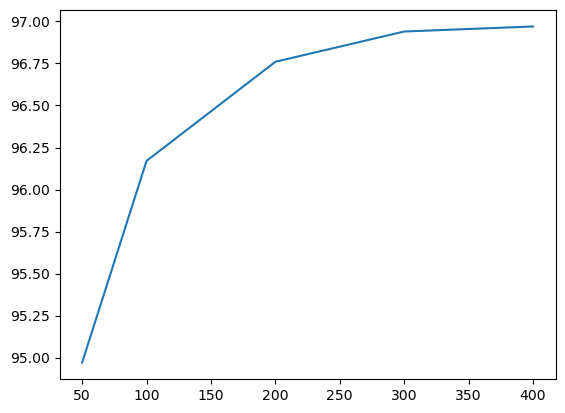

In [162]:
import matplotlib.pyplot as plt
accuracies1, size1 = runModel(1)
plt.plot(size1, accuracies1)

In [52]:
accuracies2, size2 = runModel(2)
plt.plot(size2, accuracies2)



tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.6321,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.5951, 0.0000]],
       device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.6321,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.5951, 0.0000]]],
       device='cuda:0', grad_fn=<UnsqueezeBackward0>)
tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x100 and 50x10)

In [53]:
accuracies5, size5 = runModel(5)
plt.plot(size5, accuracies5)


tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.6321, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<SubBackward0>)
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.6321, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
       device='cuda:0', grad_fn=<UnsqueezeBackward0>)
tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x100 and 50x10)

In [ ]:
accuracies100, size100 = runModel(10)
plt.plot(size100, accuracies100)

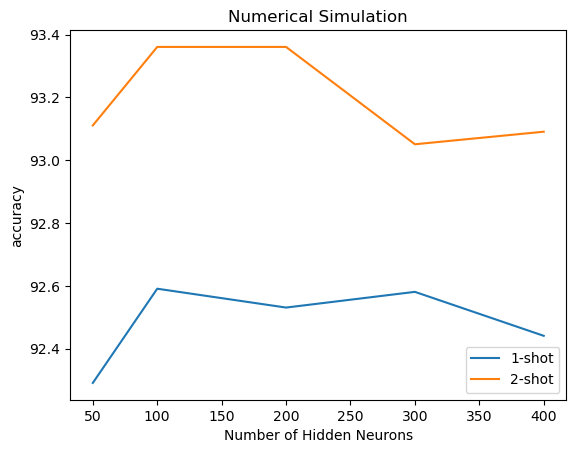

In [97]:
plt.xlabel('Number of Hidden Neurons')
plt.ylabel('accuracy')
plt.title('Numerical Simulation')
plt.plot(size1, accuracies1)
plt.plot(size2, accuracies2)
# plt.plot(size5, accuracies5)
# plt.plot(size100, accuracies100)
# plt.legend(["1-shot", "2-shot", "5-shot", "10-shot"], loc="lower right")
plt.legend(["1-shot", "2-shot"],loc="lower right")

plt.show()